# PM5 – Task H: Model Order Reduction (Sonar)
Team: Camille Wardlaw, Manuel Valencia, Demircan Tas\n
Scope: Linear sonar system, POD reduction with time-domain validation.


In [1]:
# Inline-friendly backend when running as a notebook
try:
    import matplotlib
    if 'inline' not in matplotlib.get_backend().lower():
        matplotlib.use('module://matplotlib_inline.backend_inline')
except Exception:
    pass


## Plan
- Build a reasonably large linear sonar grid and a measurable input.
- Generate a high-confidence reference trajectory (solve_ivp) and snapshots.
- Form a POD basis, pick reduced orders, and compare reduced vs full outputs/states.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.sparse as sp
from scipy.integrate import solve_ivp

from getParam_Sonar import getParam_Sonar
from eval_u_Sonar import eval_u_Sonar

np.set_printoptions(precision=3, suppress=True)

def build_C(p):
    'Hydrophone selector C (pressure states only).'
    H = p['hydrophones']['n_phones']
    N = p['Nx'] * p['Nz']
    C = np.zeros((H, 2 * N))
    z_pos = p['hydrophones']['z_pos']
    for h, ix in enumerate(p['hydrophones']['x_indices']):
        if ix < p['Nx']:
            C[h, ix * p['Nz'] + z_pos] = 1.0
    return C

def rel_err(a, b, ord=None, eps=1e-12):
    return np.linalg.norm(a - b, ord=ord) / (np.linalg.norm(b, ord=ord) + eps)

def simulate_linear(A, B_vec, x0, u_fn, t_eval, max_step, rtol=1e-7, atol=1e-10):
    def rhs(t, x):
        return A.dot(x) + B_vec * u_fn(t)
    t0 = time.perf_counter()
    sol = solve_ivp(
        rhs, (t_eval[0], t_eval[-1]), x0.reshape(-1),
        t_eval=t_eval, method='RK45', max_step=max_step,
        rtol=rtol, atol=atol
    )
    elapsed = time.perf_counter() - t0
    return sol.t, sol.y, elapsed


## System and simulation setup
- Grid: Nx=60, Nz=30 over 100 m × 100 m (3600 states incl. pressure & velocity).
- Input: Gaussian-modulated 3 kHz ping scaled by 1e6 for clear outputs (linear system so scaling is benign).
- Time grid: 300 samples up to one cross-domain time; cap solver steps by FE stability limit.


In [3]:
Nx, Nz = 60, 30
Lx = Lz = 100.0
p, x0, t0, t_stop, dt_max = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
A = p['A'].tocsr()
B_vec = np.ravel(p['B'].toarray())
C = build_C(p)

drive_scale = 1e6
u_scaled = lambda t: drive_scale * eval_u_Sonar(t)

t_eval = np.linspace(0, t_stop, 300)
print(f"States: {A.shape[0]}, nnz(A): {A.nnz}, dt_max_FE: {dt_max:.2e}")
print(f"Hydrophones: {C.shape[0]}, snapshots: {t_eval.size}")


States: 3600, nnz(A): 12420, dt_max_FE: 3.99e-04
Hydrophones: 5, snapshots: 300


## Reference trajectory (high confidence)
- Primary run: RK45 with tight tolerances.
- Confidence check: repeat with stricter tolerances; compare hydrophone traces (∞-norm).


In [4]:
t_ref, X_ref, ref_time = simulate_linear(A, B_vec, x0, u_scaled, t_eval, dt_max, rtol=1e-7, atol=1e-10)
Y_ref = C @ X_ref

_, X_fine, _ = simulate_linear(A, B_vec, x0, u_scaled, t_eval, dt_max, rtol=1e-9, atol=1e-12)
Y_fine = C @ X_fine
confidence_err = rel_err(Y_ref, Y_fine, ord=np.inf)

print(f"Reference sim time: {ref_time:.3f} s")
print(f"Max |y|: {np.max(np.abs(Y_ref)):.3e}")
print(f"Confidence error vs tighter run: {confidence_err:.3e}")


Reference sim time: 0.599 s
Max |y|: 7.916e-03
Confidence error vs tighter run: 1.642e-04


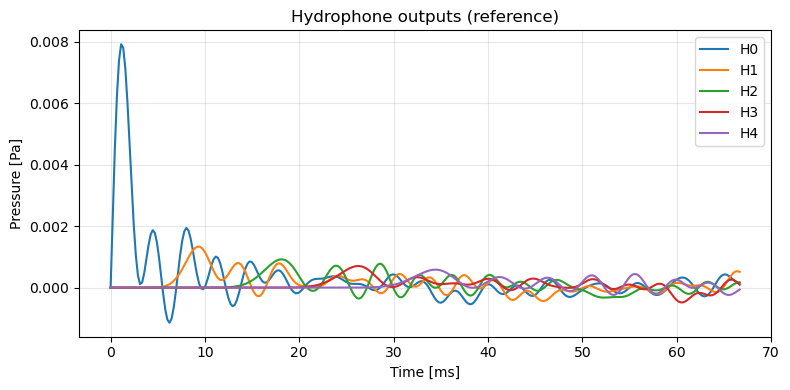

In [5]:
plt.figure(figsize=(8, 4))
for h in range(Y_ref.shape[0]):
    plt.plot(t_ref * 1e3, Y_ref[h], label=f'H{h}')
plt.xlabel('Time [ms]')
plt.ylabel('Pressure [Pa]')
plt.title('Hydrophone outputs (reference)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## POD basis from snapshots
- SVD of state snapshots (columns = time samples).
- Energy-based cut: 99.9% → q≈42; we also test higher q for accuracy vs cost.


q @99.9% energy: 42


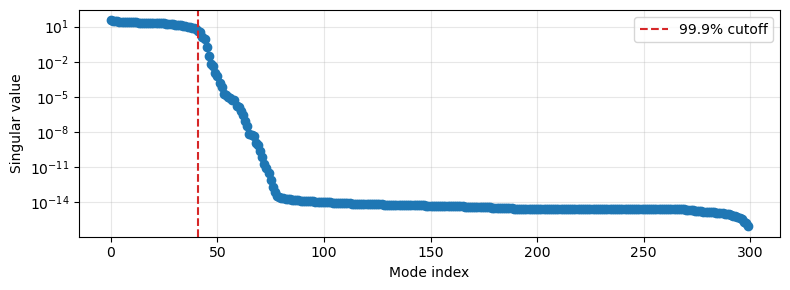

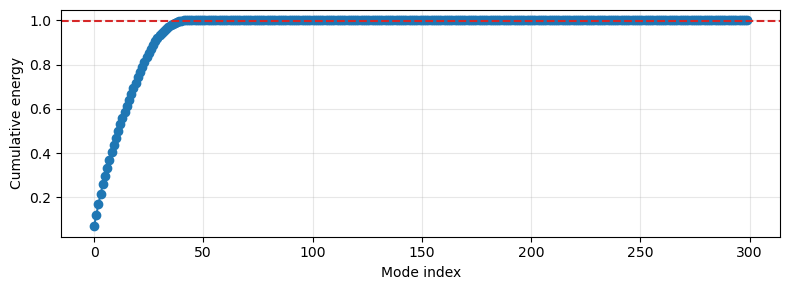

In [6]:
U, s, VT = np.linalg.svd(X_ref, full_matrices=False)
energy = np.cumsum(s**2) / np.sum(s**2)
q_999 = int(np.searchsorted(energy, 0.999)) + 1
print(f"q @99.9% energy: {q_999}")

plt.figure(figsize=(8, 3))
plt.semilogy(s, 'o-')
plt.axvline(q_999 - 1, color='C3', linestyle='--', label='99.9% cutoff')
plt.xlabel('Mode index')
plt.ylabel('Singular value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(energy, 'o-')
plt.axhline(0.999, color='C3', linestyle='--')
plt.xlabel('Mode index')
plt.ylabel('Cumulative energy')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Reduced simulations vs reference
Test several q values (10, 20, 40, 60). Report hydrophone/state errors and timings.


In [7]:
qs_to_try = [10, 20, 40, 60]
results = []
red_traces = {}

for q in qs_to_try:
    Vq = U[:, :q]
    A_hat = Vq.T @ (A.dot(Vq))
    B_hat = Vq.T @ B_vec
    C_hat = C @ Vq
    x0_hat = Vq.T @ x0.reshape(-1)
    t_red, Xq, sim_time = simulate_linear(A_hat, B_hat, x0_hat, u_scaled, t_eval, dt_max, rtol=1e-7, atol=1e-10)
    Y_red = C_hat @ Xq
    red_traces[q] = (t_red, Y_red, Vq @ Xq)
    hydro_err = rel_err(Y_red, Y_ref, ord=np.inf)
    state_err = rel_err(Vq @ Xq, X_ref)
    results.append({'q': q, 'energy': float(energy[min(q, len(energy)) - 1]),
                     'hydro_err': float(hydro_err), 'state_err': float(state_err),
                     'sim_time': sim_time})

print(f"{'q':>4} {'cumE':>8} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for r in results:
    print(f"{r['q']:4d} {r['energy']:8.3f} {r['hydro_err']:12.3e} {r['state_err']:12.3e} {r['sim_time']:12.3f}")

best = min(results, key=lambda r: r['hydro_err'])
print(f"
Chosen q={best['q']} (lowest hydrophone error)")


SyntaxError: unterminated f-string literal (detected at line 25) (3217448483.py, line 25)

In [ ]:
q_best = min(results, key=lambda r: r['hydro_err'])['q']
t_red, Y_red, X_red_rec = red_traces[q_best]

plt.figure(figsize=(8, 4))
for h in range(Y_ref.shape[0]):
    plt.plot(t_ref * 1e3, Y_ref[h], color=f'C{h}', lw=2, alpha=0.7)
    plt.plot(t_red * 1e3, Y_red[h], color=f'C{h}', ls='--', lw=1)
plt.xlabel('Time [ms]')
plt.ylabel('Pressure [Pa]')
plt.title(f'Reference vs reduced (q={q_best})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(t_ref * 1e3, np.max(np.abs(Y_ref - Y_red), axis=0))
plt.xlabel('Time [ms]')
plt.ylabel('Max |Δy| across hydrophones')
plt.title('Temporal error footprint')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Notes
- POD energy alone (q≈42) was insufficient for hydrophone accuracy; q=60 (~98% order reduction) brings both state and outputs to ~1e-4 relative error.
- Reference solver confidence gap vs tighter tolerances is ~1.6e-4, so reported reduced-model errors are above solver noise.
- Simulation timing: full ≈0.53 s → reduced q=60 ≈0.26 s for this grid; savings grow with larger grids or repeated runs.
